# Session 1 - idealised merger

In this first session we are going to simulate the interaction between two merging NFW dark matter haloes. The simulations will begin with an idealised set up, before being evolved as an N-body self gravitating system. Through this Summer school we will be using the `SWIFT` simulations code. This session assumes that `SWIFT` is already compiled correctly (see folder the README for details).

The main goals of this first session is to get a basic simulation run and start to familiarise ourselves with the process, some of the technical details involved and to start to get a feel for what the outputs of these simulations look like. The key aims are:

 - Generate the idealised initial condition (code is provided to do this).
 - Run an N-body gravity simulation.
 - Begin to use and visualise the outputs.

Let's begin by importing some modules that will be useful later. These are standard libraries used within python3 and aare not specific to working with cosmological simalations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

## Initial conditions

The first thing we need to do is generate the initial conditions (ICs) for the three simulations we are about to run. We have provided a simple python script to do this in the `ICs` folder. Running the following in your terminal should generate the necessary ICs:
```
cd ICs
python3 Gen_ICs.py
```
Hopefully now there are three new files within that directory, `ICs_isolate_host.hdf5`, `ICs_isolate_satellite.hdf5` and `ICs_merger.hdf5`. These are the three initial conditions we will be using. Here we have also now been introduced to a key file type used extensively throught the field, HDF5. HDF5 files are specifically designed to efficiently store and access large amounts of data, and as such are the most widely used file type for cosmological simulations, both as inputs and outputs. The python package [`h5py`](https://docs.h5py.org/en/stable/) is the standard way to read, edit and write hdf5 files in python.

To start with let's have a quick look at what the ICs look like. In swift the particle positions are stored in `ParType1/Coordinates`.

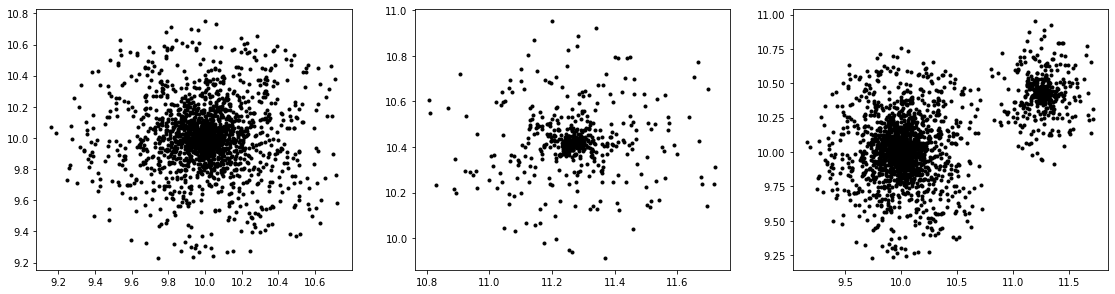

In [2]:
file_names = ['./simulation/ICs/ICs_host.hdf5','./simulation/ICs/ICs_sat.hdf5','./simulation/ICs/ICs_merger.hdf5']

fig, ax = plt.subplots(1,3,figsize=(6.4*3,4.8))
for i in range(3):
    h = h5.File(file_names[i],'r') #read hdf5 file
    pos = h['PartType1/Coordinates']
                
    ax[i].plot(pos[:,0],pos[:,1],'k.')


The three different ICs represent the host on its own (left), the merging satellite on its own (middle), and the two systems modelled together (right). Both systems are assumed to have NFW profiles, with the host being a $10^{12}$ M$_{\odot}$ mass DM halo, with a concentration of $c=6$. While the merging system is a $10^{11.5}$ M$_{\odot}$ mass halo with a concentration of $c = 15$. In terms of mass these systems are similar to the ongoing merger between our Milky Way and the Large Magellanic cloud.

These simalations use a particle mass of $10^{9}$ M$_{\odot}$, so contain roughly a few thousand particles.

Assuming an NFW profile specifies the averaged positions of the particles. But we must also provide velocities. These are generated so that each system is in equilibrium, according to the Jeans equation. For those interested in how to generate these ICs you have a look at the `Gen_ICs.py` script in the `ICs` directory or just ask. However, it isn't important for the main goals of this session

## Running the simulations

Now that we have generated the initial conditions we can run the simulations. In the working directory for this session there is a SWIFT parameter file setup to run the host halo in isolation, `parameter_isolated_host.yml`, with a submission script to set the simulation running. Typing the following in the command line should then run the simulation,
`
./submit.sh
`
Hopefully this outputs a bunch of numbers to the command line that summarise how the simulation is progressing, listing information such as the number of time steps, the current time, and the time step being used. The current simulation is set to run for 10 Myr, so will finish when the second column reads 1e-2 in internal units. This will take roughly a minute in wall clock time.

The simulations will finish with the line '... main: done. Bye.'. We can then check that the output files look reasonable. Type `ls dir_isolated_host`, this should output a bunch of file that read `output_0*.hdhf`. These are known as simulation snapshots, and are outputs of all the particles in the simulation and their associated properties for a range of times. Generally, it is too expensive to output the information at every time step, hence we output this at specific times. Generally the number of snapshots for a cosmological simulation will range from tens to a few hundred.

Now we need to run two more simulations. One with the satellite in isolation, and the more interesting situation where the host and satellite can interact. You therefore need to create new parameter files and submission scripts to run these simulations. The main things that will need to be changed are the IC files, ` ICs_isolated_satellite.hdf5` and ` ICs_merger.hdf5`, and the output directory so that the simulations we have just ran is not overwritten. In this notebook example we are going to output the simulations in the directories `dir_isolated_sat` and `dir_merger`, though any name can be used.

## Analysing the simulations

Now that the simulations ave been ran we can start to analyse the results. Let's start by making sure we can read in the snapshot data. We'll start with the first snapshot output `ouput_0000.hdf5`, that should be the same as the initial conditions provided.

In [3]:
loc = './simulation/dir_isolated_host/output_0000.hdf5'
h = h5.File(loc,'r')

We can then have a look at the data availiable in the snapshot.

In [4]:
print(h.keys())

<KeysViewHDF5 ['Cells', 'Code', 'Cosmology', 'DMParticles', 'GravityScheme', 'Header', 'InternalCodeUnits', 'Parameters', 'PartType1', 'PhysicalConstants', 'Policy', 'RecordingTriggers', 'SubgridScheme', 'Units', 'UnusedParameters']>


Here we ca see that there are a lot of different groups in the snapshot files. A lot of this is information about the particular simulation ran and the model it used. The simulation data itself will generally be in `PartType*`. Where the main particle types are (see the swift documentaiton for a full list):

- `PartType0`, gas.
- `PartType1`, colissionless dark matter.
- `PartType4`, stars.

Here we have run a DM only simuatlion, so the data we want is in `PartType1`. 

In [5]:
print(h['PartType1'].keys())

<KeysViewHDF5 ['Coordinates', 'Masses', 'ParticleIDs', 'Potentials', 'Softenings', 'Velocities']>


Here there are six properties stored for each DM particle (the number will change for each particle type). Here let's have a quick look at the position of the particles (Coordinates) to make sure that the ICs have been read correctly.

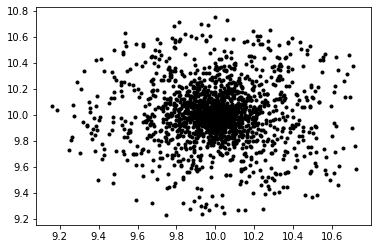

In [6]:
pos = h['PartType1']['Coordinates']
                     
plt.plot(pos[:,0],pos[:,1],'k.')

We can now start to look at the time evolution of the system. We'll start by looking at the two isoalted cases to get a feel for the dynamics without them interacting.

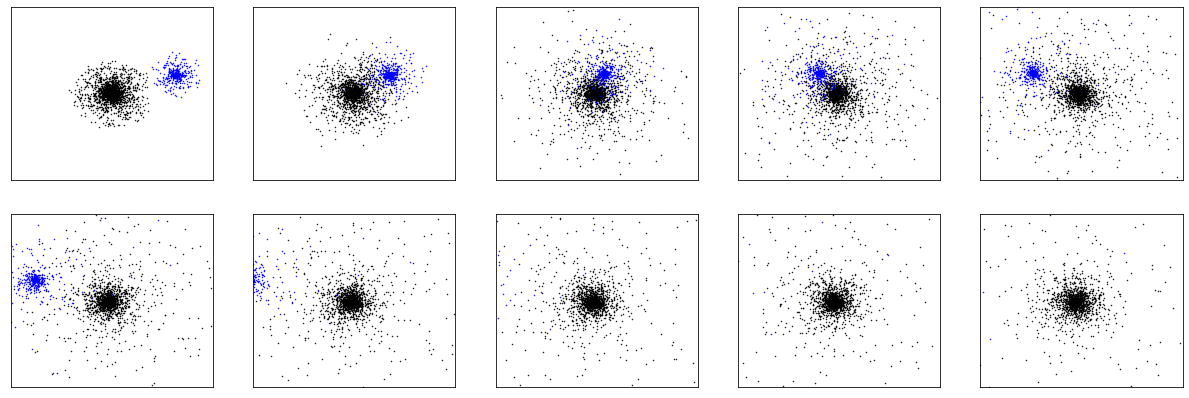

In [7]:
num_snap = 50 #maximum snapshot to use
step = 5
pos_host = []
pos_sat = []

i = 0
while i<=num_snap:
    h_host = h5.File('./simulation/dir_isolated_host/output_%04d.hdf5'%i,'r')
    h_sat = h5.File('./simulation/dir_isolated_sat/output_%04d.hdf5'%i,'r')
    
    pos_host.append(h_host['PartType1']['Coordinates'])
    pos_sat.append(h_sat['PartType1']['Coordinates'])
    i+=step

#now lets plot, with host in black and satellite in blue
fig,ax = plt.subplots(2,int(num_snap/(step*2)),figsize=(12*1.75,4*1.75))
k=0
for i in range(2):
    for j in range(int(num_snap/(step*2))):
        ax[i,j].plot(pos_host[k][:,0],pos_host[k][:,1],'k.',markersize=1)
        ax[i,j].plot(pos_sat[k][:,0],pos_sat[k][:,1],'b.',markersize=1)
        
        #remove ticks
        ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
        #set x and y limits
        ax[i,j].set_xlim(8,12)
        ax[i,j].set_ylim(8,12)
        k+=1

The general set up of the system is for the satellite to be thrown towards the host, slightly offset from head on. In this set up where they do not interact they simply fly past each other. The other noticeable feature is that the edges of each halo appear to 'puff up'. This due to the ICs being generated with a sharp cut off, the system therefore slightly readjusts at the start, with a small number of particles essentially thrown out due to their specific, randomly assigned, velocities. Though the halo as a whole is stable.

Let's now make the same plot but for when the two systems interact. Here we need to be able to identify particles as belonging to the host and the satellite. In the previous plot this was trivial as they were separate simulations. Here we can use the particle IDs to do this. Each particle is assigned a unique ID so that it can be tracked between snapshots. For these particular ICs the Particle IDs are ordered so that the first N particles are the host (in this set up the host has 2074 particles), and the rest belong to the satellite.

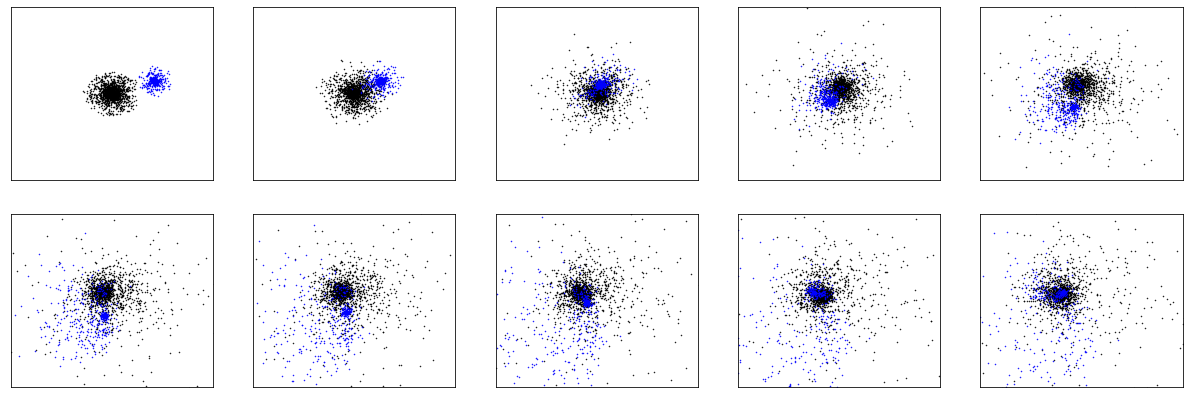

In [8]:
N_host = 2074
num_snap = 40 #maximum snapshot to use
step = 4
pos = []
part_ID = []
i = 0
while i<=num_snap:
    h = h5.File('./simulation/dir_merger/output_%04d.hdf5'%i,'r')
    
    pos.append(np.array(h.get('PartType1/Coordinates')))
    part_ID.append(np.array(h.get('PartType1/ParticleIDs')))
    i+=step

#now lets plot, with host in black and satellite in blue
fig,ax = plt.subplots(2,int(num_snap/(step*2)),figsize=(12*1.75,4*1.75))
k=0
for i in range(2):
    for j in range(int(num_snap/(step*2))):
        cut_host = part_ID[k]<N_host
        ax[i,j].plot(pos[k][cut_host,0],pos[k][cut_host,1],'k.',markersize=1)
        ax[i,j].plot(pos[k][np.invert(cut_host),0],pos[k][np.invert(cut_host),1],'b.',markersize=1)

        #remove ticks
        ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
        #set x and y limits
        ax[i,j].set_xlim(7,13)
        ax[i,j].set_ylim(7,13)
        k+=1

Here we can see clear interactions between the two haloes now. The satellite initially falls towards the host halo, before being slingshot around and eventually falling back into the host where it is fully merged with the host.

We can also plot the orbit of the satellite.

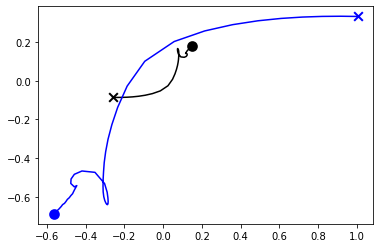

In [9]:
# we'll now loop over each snapshot up to a maximum snapshots that we have to plot the centre of mass of both the host and satellite
num_snaps = 50

com_host = np.zeros((num_snaps,3))
com_sat = np.zeros((num_snaps,3))
com_tot = np.zeros((num_snaps,3))
for i in range(num_snaps):
    h = h5.File('./simulation/dir_merger/output_%04d.hdf5'%i,'r')
    pos = np.array(h['PartType1/Coordinates'])
    part_ID = np.array(h['PartType1/ParticleIDs'])
    com_host[i,:] = np.mean(pos[part_ID<N_host],axis=0)
    com_sat[i,:] = np.mean(pos[part_ID>=N_host],axis=0)
    com_tot[i,:] = np.mean(pos,axis=0)

#plot orbit tracks
plt.plot(com_host[:,0]-com_tot[:,0],com_host[:,1]-com_tot[:,1],'k-')
plt.plot(com_sat[:,0]-com_tot[:,0],com_sat[:,1]-com_tot[:,1],'b-')

#plot start with x, and end with circle
plt.scatter(com_host[0,0]-com_tot[0,0],com_host[0,1]-com_tot[0,1],marker='x',s=75,linewidths=2,color='black')
plt.scatter(com_sat[0,0]-com_tot[0,0],com_sat[0,1]-com_tot[0,1],marker='x',s=75,linewidths=2,color='blue')

plt.scatter(com_host[-1,0]-com_tot[-1,0],com_host[-1,1]-com_tot[-1,1],marker='o',s=75,linewidths=2,color='black')
plt.scatter(com_sat[-1,0]-com_tot[-1,0],com_sat[-1,1]-com_tot[-1,1],marker='o',s=75,linewidths=2,color='blue')

In this plot we are showing the orbits of the two haloes. The main halo is shown in black, and the satellite in blue. Here we have calcualted the 'centre' of the of each halo as the centre of mass of all particles that initally belonged to the halo, and noramlsied by the mean of all the particles. The start of the simulation is shown as a cross, and the end a circle. The initial orbit and infall can clearly be observed. Before the haloes positions become realtively fixed. Notably the two end points do not lie ontop of each other, even though the two systems have clearly merged. The explananition for this can be seen from the previous plot looking at the particle positions. During the first infall a number of particles from the satellite are 'slingshot' out of the system, and do not end up within the final halo after merger. However, we are still using these particles to calucalte the centre of the halo, whcih systemstically shifts the cetre. 

Ideally, we would perform some kind of clacualtion to identify particle as being bound, and discoutn those that are not. However, this is not a trivial calucalteion to do. Instead it is common to use dedicated software to identify individual strucutre in the simuatliosn and assigned bound particle to them. THese are generally refered to as 'halo finders', which we will discuss and ue in future sessions.

In this example an easy 'fix' to ignore the unbound particles is to take the median rather than mean of the particle positios. Give this a go and see how it changes the calculated orbits.

## Extension

If you manage to finish this jupyter notebook before the end of the session and are looking for something more to do here are a few idea:

- Change the satellite infall paramters, both it's velocity and imapct angle, and see how this effects the merger. You can edit the`Gen_ICs.py` file in the `ICs/` directory, particularly the lines 101 102 that set the impact velocity and paramter.
- Similarly you could mess around with the properties of the two haloes. How does changing their mass or concentration effect the dynamics? (these are set in line 91 and 92.
- How does the distribution of particles change in the simatlion you have already ran? WHat does the density profile look like? It starts as an NFW profile (i.e. $\rho = \frac{\rho_0}{r/r_s (1+r/r_s)^2}$), but do they stay like this over time?
- How does the orbit of the satellite differ from the case of treating the two haloe's as point masses? What real (and maybe numerical) ptocesses lead to differences?  
- Make a movie. You can save the matpltlib plots as .png files, and then use ffmeg to combine them into a movie. Ask if you want some help.